In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
from scipy.interpolate import interp1d
warnings.simplefilter(action="ignore", category=FutureWarning)

### Data Input

In [2]:
iris_data_path = 'iris.data'
mush_data_path = 'agaricus-lepiota.data'

In [3]:
mush_header = [
    "edible=e, poisonous=p", # Target
    "cap-shape", "cap-surface", "cap-color", "bruises?",
    "odor", "gill-attachment", "gill-spacing", "gill-size", "gill-color",
    "stalk-shape", "stalk-root", "stalk-surface-above-ring", "stalk-surface-below-ring",
    "stalk-color-above-ring", "stalk-color-below-ring", "veil-type", "veil-color",
    "ring-number", "ring-type", "spore-print-color", "population", "habitat"
]

In [4]:
iris_header = [
    "sepal length", "sepal width",
    "petal length", "petal width",
    "class" # Target
]

In [5]:
iris_data = pd.read_csv(iris_data_path, header = None)
mush_data = pd.read_csv(mush_data_path, header = None)

iris_data.columns = iris_header
mush_data.columns = mush_header

print(f'Iris data shape = {iris_data.shape}')
print(f'Mush data shape = {mush_data.shape}')

Iris data shape = (150, 5)
Mush data shape = (8124, 23)


### Data Visualization

#### Mushroom

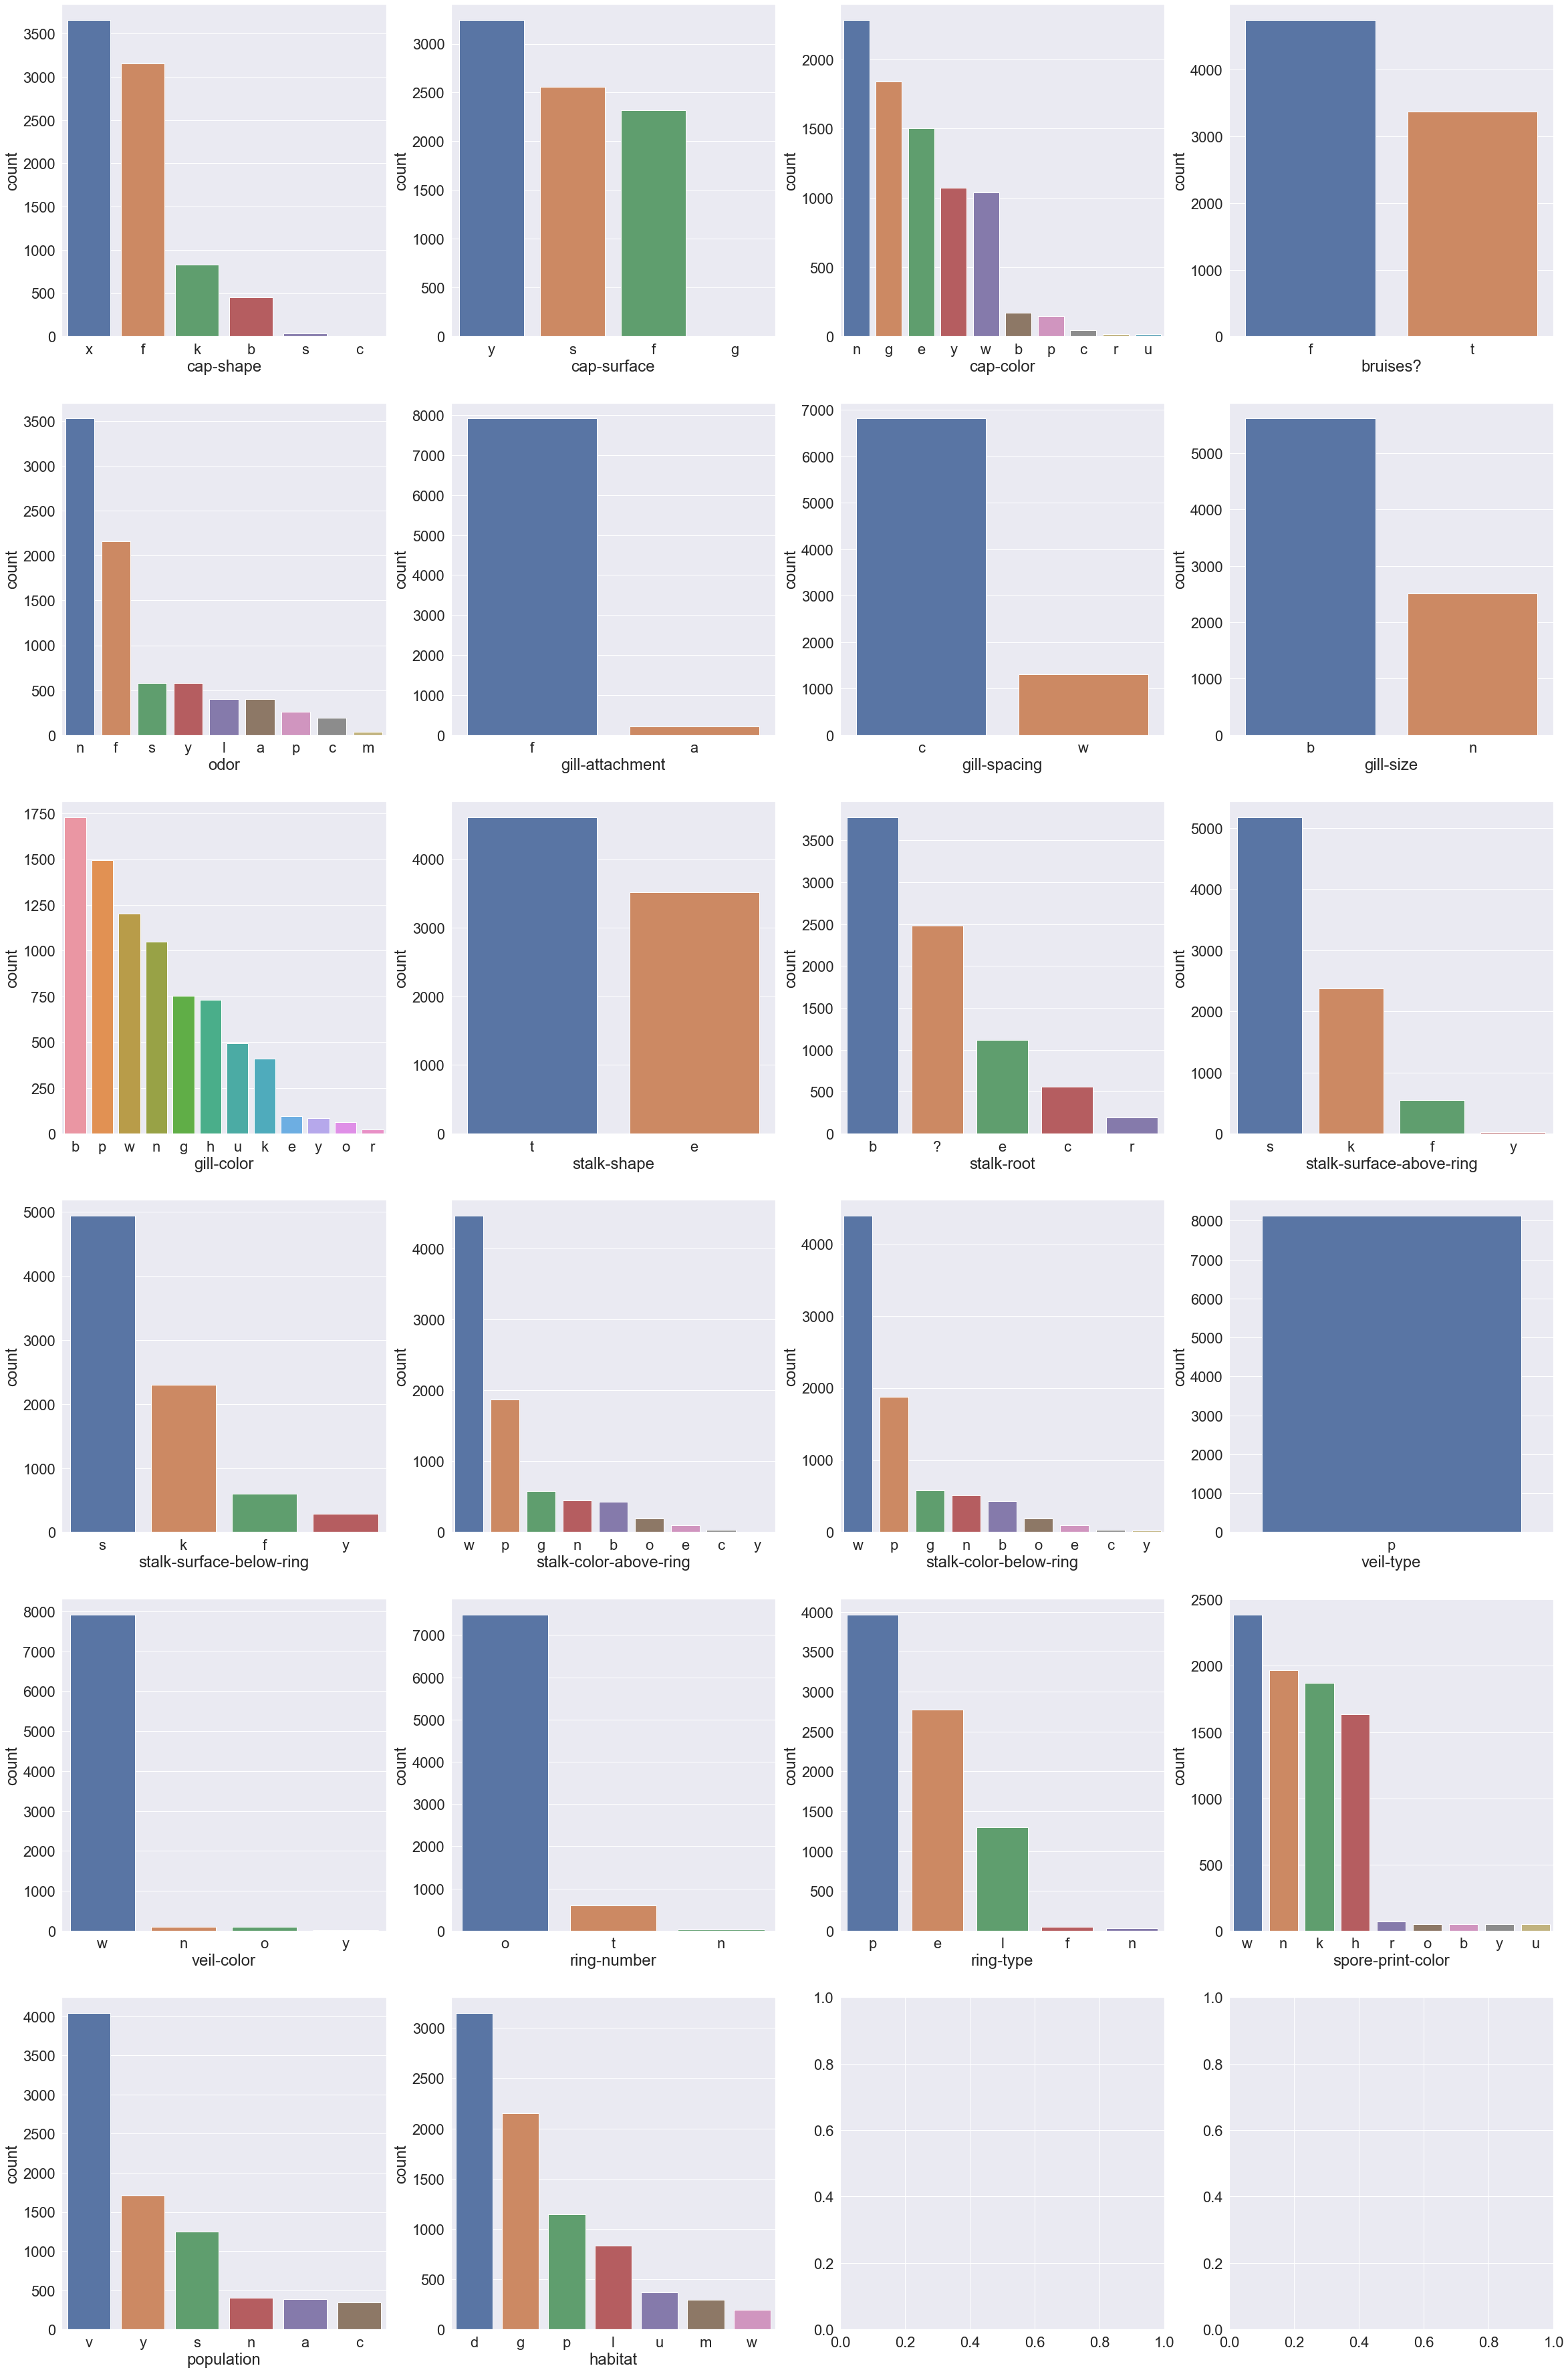

In [6]:
num_features = mush_data.shape[1]

num_y = 4
num_x = (num_features + 3) // num_y

sns.set(font_scale = 2)
fig, axes = plt.subplots(num_x, num_y, sharex = False, figsize=(40, 64))
now_x = 0
now_y = 0

for i in range(1, num_features):
    now_data = mush_data[mush_header[i]].tolist()
    fet_data = [j for j in set(now_data)]
    cnt_data = [now_data.count(j) for j in fet_data ]
    
    now_df = pd.DataFrame({'feature' : fet_data, 'count' : cnt_data})
    now_df = now_df.sort_values("count",ascending=False)
    
    p = sns.barplot(x = 'feature', y = 'count', data = now_df, ax = axes[now_x][now_y])
    p.set(xlabel = mush_header[i], ylabel = "count")
    now_y += 1
    if now_y == num_y:
        now_y = 0
        now_x += 1
        
plt.savefig('Mushroom_features_distribution.png')

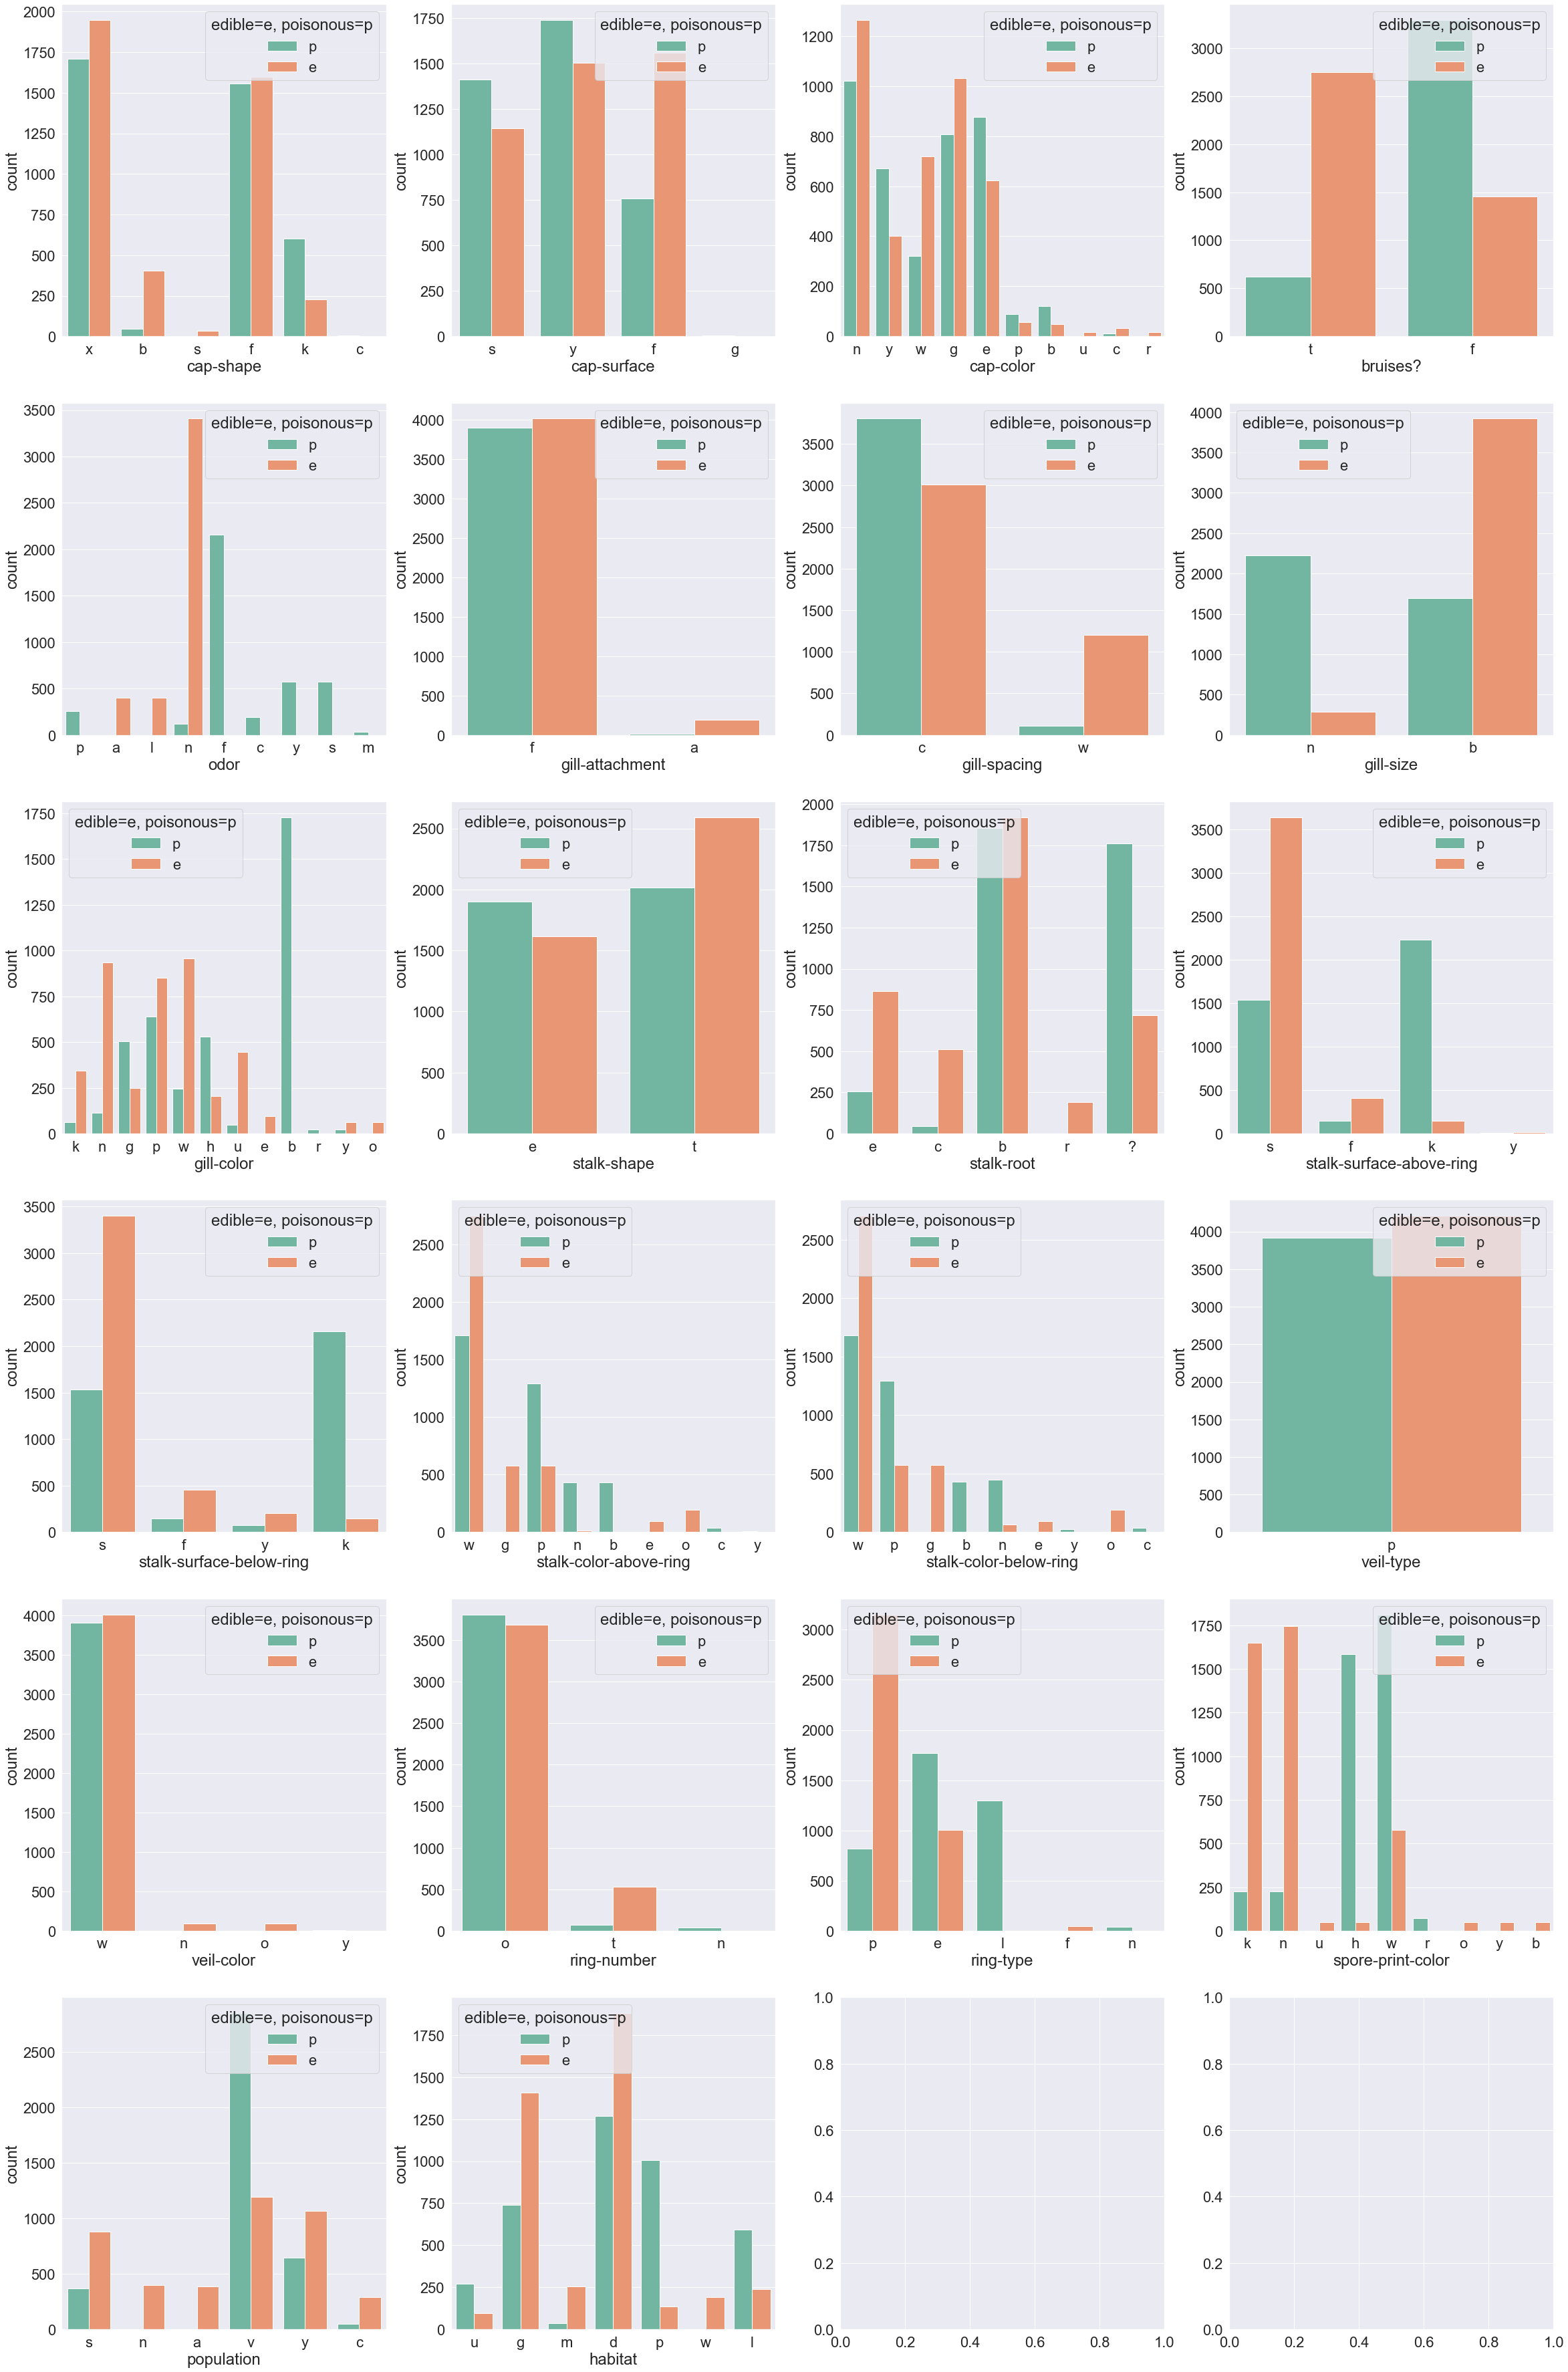

In [7]:
num_features = mush_data.shape[1]

num_y = 4
num_x = (num_features + 3) // num_y

fig, axes = plt.subplots(num_x, num_y, sharex = False, figsize=(40, 64))
now_x = 0
now_y = 0

for i in range(1, num_features):
    now_data = mush_data[[mush_header[0], mush_header[i]]]
    p = sns.countplot(
            hue = mush_header[0], 
            x = mush_header[i], 
            data = now_data, 
            ax = axes[now_x][now_y], palette = "Set2"
    )
    p.set(xlabel = mush_header[i], ylabel = "count")
    now_y += 1
    if now_y == num_y:
        now_y = 0
        now_x += 1

        
plt.savefig('Mushroom_target_feature.png')

####  Iris

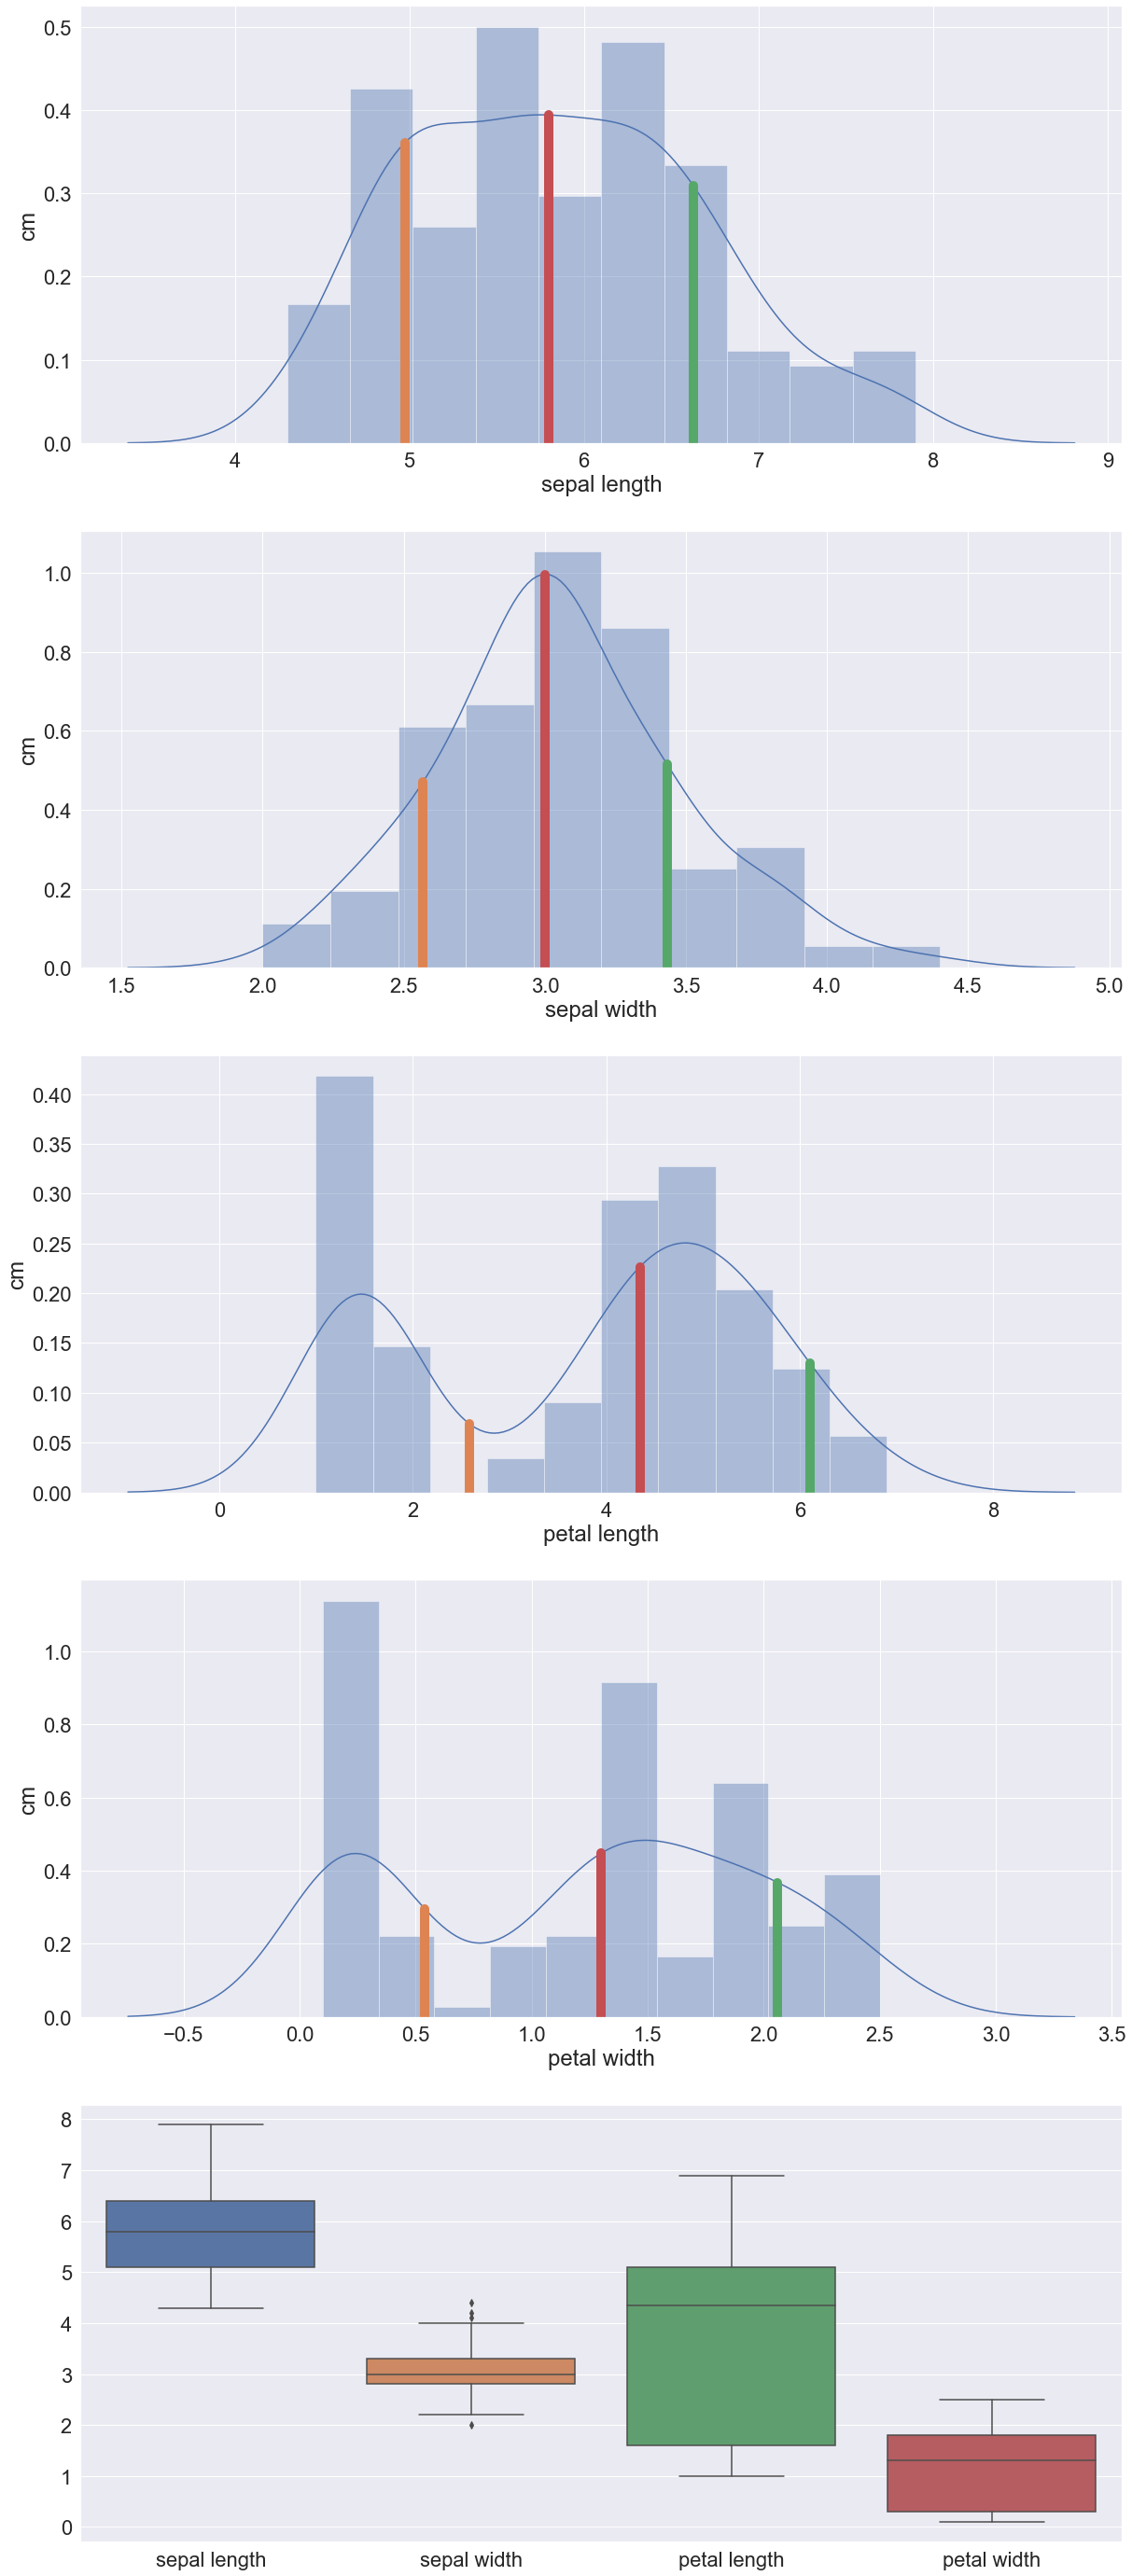

In [8]:
num_features = iris_data.shape[1]
now_linewidt = 10

sns.set(font_scale = 2)
fig, axes = plt.subplots(num_features, sharex = False, figsize=(20, 50))

for i in range(num_features - 1):
    now_data = iris_data[iris_header[i]]
    
    p = sns.distplot(x = now_data, ax = axes[i], bins = 10)
    p.set(xlabel = iris_header[i], ylabel = "cm")
    
    median = np.median(now_data)
    sigma = np.std(now_data)

    low = median - sigma
    hi = median + sigma
    
    line = p.lines[0].get_data()
    ipf = interp1d(x=line[0], y=line[1])

    p.plot([low, low], [0, ipf(low)], linewidth = now_linewidt)
    p.plot([hi, hi], [0, ipf(hi)], linewidth = now_linewidt)
    p.plot([median, median], [0, ipf(median)], linewidth = now_linewidt)

sns.boxplot(data = iris_data, ax = axes[num_features - 1])
plt.savefig('Iris_features_distribution.png')

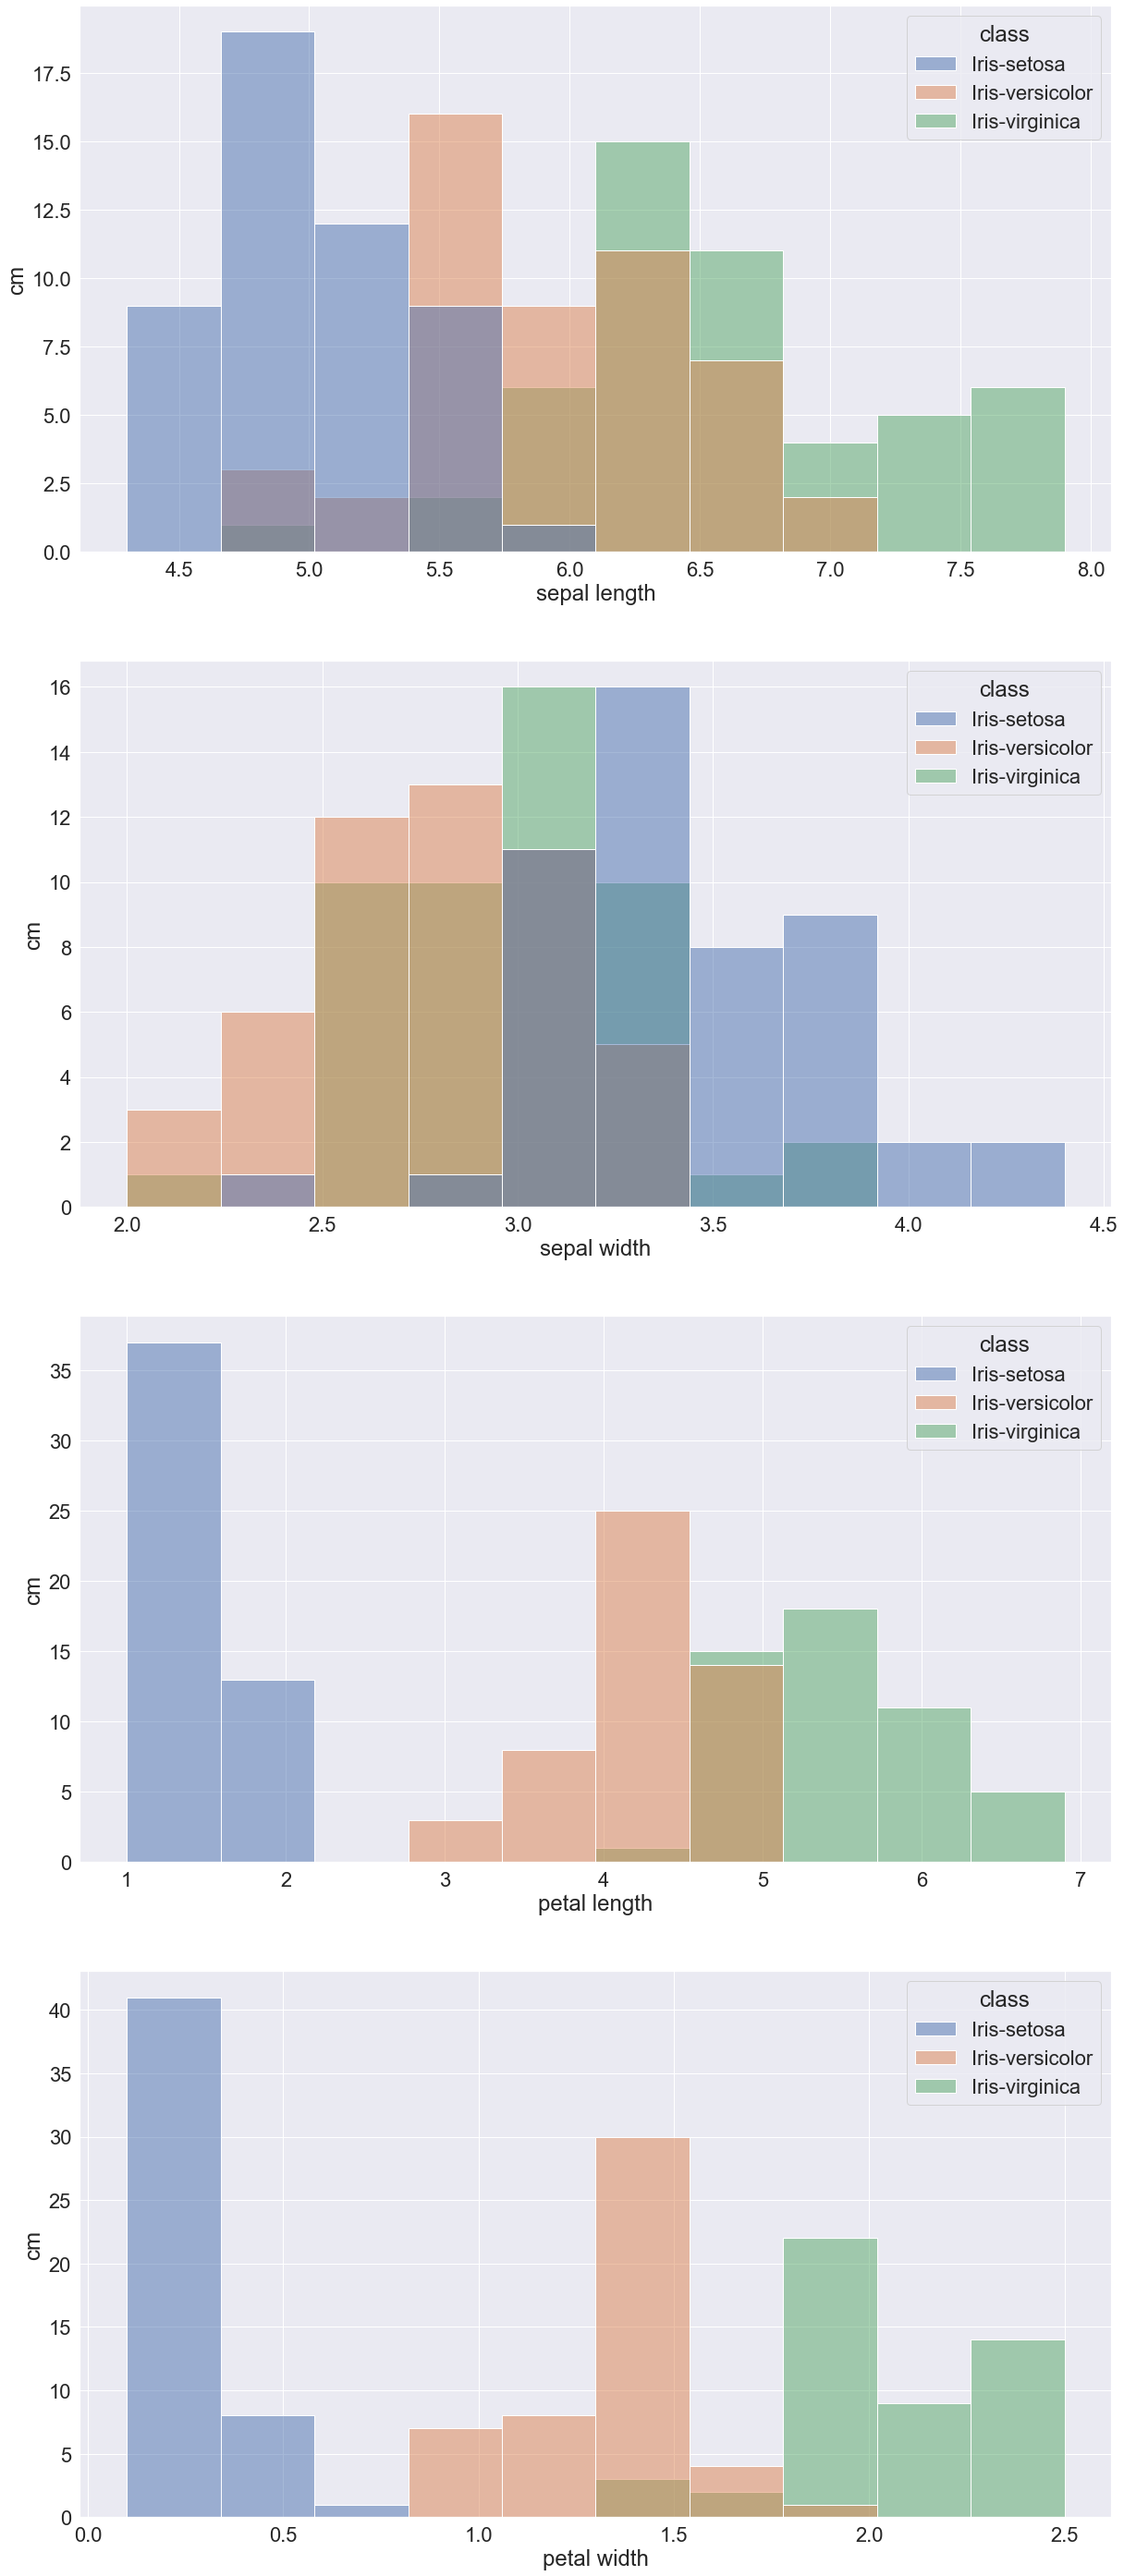

In [9]:
num_features = iris_data.shape[1]

sns.set(font_scale = 2)
fig, axes = plt.subplots(num_features - 1, sharex = False, figsize=(20, 50))

for i in range(num_features - 1):
    now_data = iris_data[[iris_header[i], 'class']]
    
    p = sns.histplot(x = iris_header[i], hue = "class", data = now_data, ax = axes[i], bins = 10)
    p.set(xlabel = iris_header[i], ylabel = "cm")

plt.savefig('Iris_target_feature.png')

### Data Preprocessing

#### Origin size
Iris data shape = (150, 5)
Mush data shape = (8124, 23)

In [10]:
iris_data_drop = iris_data.replace(['', ' ', '?'], np.nan)
mush_data_drop = mush_data.replace(['', ' ', '?'], np.nan)

iris_data_drop = iris_data_drop.dropna(axis = 'columns')
mush_data_drop = mush_data_drop.dropna(axis = 'columns')

print(f'Iris data after drop shape = {iris_data_drop.shape}')
print(f'Mush data after drop shape = {mush_data_drop.shape}')

Iris data after drop shape = (150, 5)
Mush data after drop shape = (8124, 22)


In [11]:
from sklearn.preprocessing import OrdinalEncoder

mush_x = mush_data_drop.drop(mush_header[0] , axis = 1)
mush_y = mush_data_drop[mush_header[0]]
mush_label = list(set(mush_y.tolist()))

iris_x = iris_data_drop.drop(iris_header[-1], axis = 1)
iris_y = iris_data_drop[iris_header[-1]]
iris_label = list(set(iris_y.tolist()))

enc = OrdinalEncoder()
enc.fit(mush_x)
mush_x = enc.transform(mush_x)

iris_x = iris_x.to_numpy()
iris_y = iris_y.to_numpy()

### Model Construction

In [12]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn import model_selection
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, precision_score
from sklearn.metrics import classification_report

from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action="ignore", category=ConvergenceWarning)

In [13]:
def print_heatmap(mat, title):
    sns.heatmap(mat, square= True, annot=True, cbar= True)
    plt.xlabel("Predicted value")
    plt.ylabel("True value")
    plt.title(f"{title}")
    plt.show()

In [14]:
def get_Result_Dic(y_test, y_predict, now_label, title, draw = True) -> dict:
    ret = {}
    
    ret['accuracy'] = accuracy_score(y_test, y_predict)
    ret['mat'] = pd.DataFrame(
        confusion_matrix(y_test, y_predict, labels = now_label),
        index = now_label,
        columns = now_label
    )
    ret['recall'] = recall_score(y_test, y_predict, average=None, labels = now_label)
    ret['precision'] = precision_score(y_test, y_predict, average=None, labels = now_label)
    ret['report'] = classification_report(
        y_test, y_predict, target_names = now_label
    )
    if draw == False:
        return ret 
    
    print_heatmap(ret['mat'], title)
    
    return ret

#### Mushroom

In [15]:
mush_result = {}

In [16]:
def mush_holdout_lap(now_alpha = 1e3):
    X_train, X_test, Y_train, Y_test = model_selection.train_test_split(
            mush_x, mush_y, test_size=0.30, shuffle=True, random_state=50)

    clf = MultinomialNB(alpha = now_alpha)
    clf.fit(X_train, Y_train)
    y_predict = clf.predict(X_test)
    
    ret = get_Result_Dic(
        Y_test, y_predict, mush_label, f"Mushroom holdout alpha = {now_alpha}")
    
    mush_result[f'Holdout alpha = {now_alpha}'] = ret
    print(ret['report'])

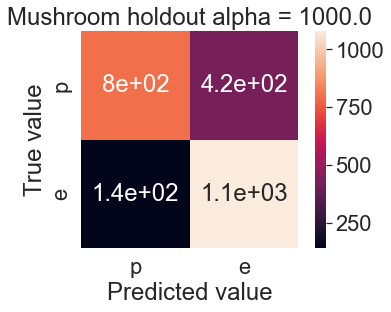

              precision    recall  f1-score   support

           p       0.72      0.89      0.79      1219
           e       0.85      0.65      0.74      1219

    accuracy                           0.77      2438
   macro avg       0.78      0.77      0.77      2438
weighted avg       0.78      0.77      0.77      2438



In [17]:
#  Holdout with Laplace smoothing
mush_holdout_lap()

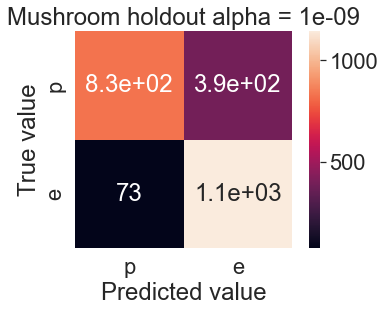

              precision    recall  f1-score   support

           p       0.75      0.94      0.83      1219
           e       0.92      0.68      0.78      1219

    accuracy                           0.81      2438
   macro avg       0.83      0.81      0.81      2438
weighted avg       0.83      0.81      0.81      2438



In [18]:
#  Holdout without Laplace smoothing (alpha = 1e-9)
mush_holdout_lap(1e-9)

In [19]:
def mush_kfold_lap(now_alpha = 1e3):
    kfold = model_selection.KFold(n_splits=3, shuffle=True, random_state=50)
    kfold.get_n_splits(mush_x)
    
    flag = 0
    rec_sum = None
    acc_sum = None
    mat_sum = None
    pre_sum = None
    for train_index, test_index in kfold.split(mush_x):
        clf = MultinomialNB(alpha = now_alpha)
        clf.fit(mush_x[train_index], mush_y[train_index])
        y_predict = clf.predict(mush_x[test_index])

        ret = get_Result_Dic(
            mush_y[test_index], y_predict, mush_label, f"Mushroom alpha = {now_alpha}",
            draw = False
        )
        mush_result[f'K-fold alpha = {now_alpha}'] = ret
        if flag != 0: 
            flag += 1
            mat_sum += ret['mat']
            rec_sum += ret['recall']
            acc_sum += ret['accuracy']
            pre_sum += ret['precision']
        else:
            flag = 1
            mat_sum = ret['mat']
            rec_sum = ret['recall']
            acc_sum = ret['accuracy']
            pre_sum = ret['precision']
    
    print(f'Accuracy ave. = {acc_sum / flag}')
    print(f'Recall ave. = {rec_sum / flag}')
    print(f'Precision ave. = {pre_sum / flag}')
    print(mush_label)
    print_heatmap(mat_sum, f'Mushroom kfold sum, alpha = {now_alpha}')
            

Accuracy ave. = 0.774741506646972
Recall ave. = [0.65355775 0.88782751]
Precision ave. = [0.84378999 0.73339463]
['p', 'e']


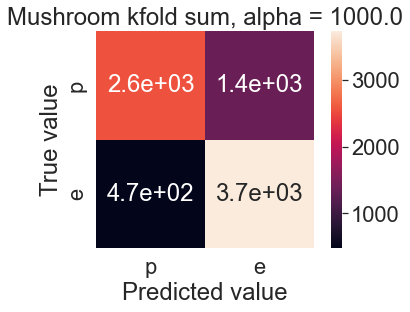

In [20]:
#  k-fold with Laplace smoothing (alpha = 1e3)
mush_kfold_lap()

Accuracy ave. = 0.8136386016740521
Recall ave. = [0.67966638 0.93829421]
Precision ave. = [0.91077083 0.75876575]
['p', 'e']


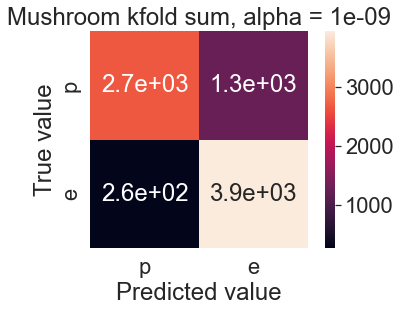

In [21]:
#  k-fold without Laplace smoothing (alpha = 1e-9)
mush_kfold_lap(1e-9)

#### Iris

In [22]:
def iris_holdout():
    X_train, X_test, Y_train, Y_test = model_selection.train_test_split(
            iris_x, iris_y, test_size=0.30, shuffle=True, random_state=50)
    
    clf = GaussianNB()
    clf.fit(X_train, Y_train)
    
    y_predict = clf.predict(X_test)
    
    ret = get_Result_Dic(Y_test, y_predict, iris_label, f"Iris holdout")
    print(ret['report'])

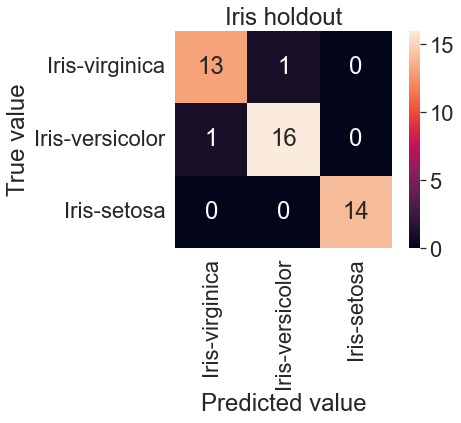

                 precision    recall  f1-score   support

 Iris-virginica       1.00      1.00      1.00        14
Iris-versicolor       0.94      0.94      0.94        17
    Iris-setosa       0.93      0.93      0.93        14

       accuracy                           0.96        45
      macro avg       0.96      0.96      0.96        45
   weighted avg       0.96      0.96      0.96        45



In [23]:
iris_holdout()

In [24]:
def iris_kfold():
    kfold = model_selection.KFold(n_splits=3, shuffle=True, random_state=50)
    kfold.get_n_splits(iris_x)
    
    flag = 0
    rec_sum = None
    acc_sum = None
    mat_sum = None
    pre_sum = None
    for train_index, test_index in kfold.split(iris_x):
        clf = GaussianNB()
        
        clf.fit(iris_x[train_index], iris_y[train_index])
        y_predict = clf.predict(iris_x[test_index])

        ret = get_Result_Dic(
            iris_y[test_index], y_predict, iris_label, f"Iris",
            draw = False
        )
        if flag != 0: 
            flag += 1
            mat_sum += ret['mat']
            rec_sum += ret['recall']
            acc_sum += ret['accuracy']
            pre_sum += ret['precision']
        else:
            flag = 1
            mat_sum = ret['mat']
            rec_sum = ret['recall']
            acc_sum = ret['accuracy']
            pre_sum = ret['precision']
    
    print(f'Accuracy ave. = {acc_sum / flag}')
    print(f'Recall ave. = {rec_sum / flag}')
    print(f'Precision ave. = {pre_sum / flag}')
    print(iris_label)
    print_heatmap(mat_sum, f'Iris kfold sum')

Accuracy ave. = 0.9533333333333333
Recall ave. = [0.92916667 0.93995098 1.        ]
Precision ave. = [0.93842593 0.9248366  1.        ]
['Iris-virginica', 'Iris-versicolor', 'Iris-setosa']


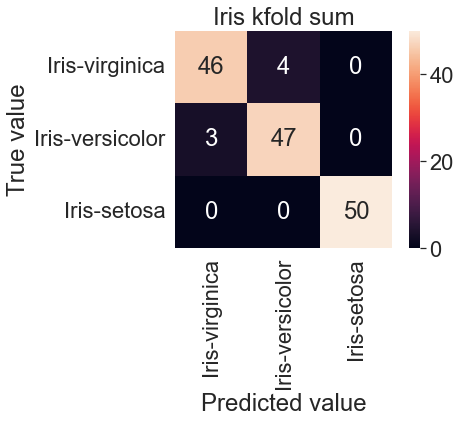

In [25]:
iris_kfold()

### Results Comparison & Conclusion

In [27]:
df = pd.DataFrame.from_dict(mush_result, orient = 'index')
df = df.drop('report', axis = 1)
# df = df.drop('recall', axis = 1)
# df = df.drop('precision', axis = 1)
df.head()

,accuracy,mat,recall,precision
Holdout alpha = 1000.0,0.769073,p e p 795 424 e 139 1080,"[0.6521739130434783, 0.8859721082854799]","[0.8511777301927195, 0.7180851063829787]"
Holdout alpha = 1e-09,0.810500,p e p 830 389 e 73 1146,"[0.6808859721082855, 0.9401148482362592]","[0.9191583610188261, 0.7465798045602606]"
K-fold alpha = 1000.0,0.783604,p e p 852 434 e 152 1270,"[0.6625194401244168, 0.8931082981715893]","[0.848605577689243, 0.7453051643192489]"
K-fold alpha = 1e-09,0.816100,p e p 882 404 e 94 1328,"[0.6858475894245724, 0.9338959212376934]","[0.9036885245901639, 0.766743648960739]"


### Questions

#### Q1. 𝑃(𝑋𝑠𝑡𝑎𝑙𝑘−𝑐𝑜𝑙𝑜𝑟−𝑏𝑒𝑙𝑜𝑤−𝑟𝑖𝑛𝑔|𝑌=𝑒) with and without Laplace smoothing by bar charts 

[Text(0.5, 1.0, 'P(color | e)  with Laplace = 1000')]

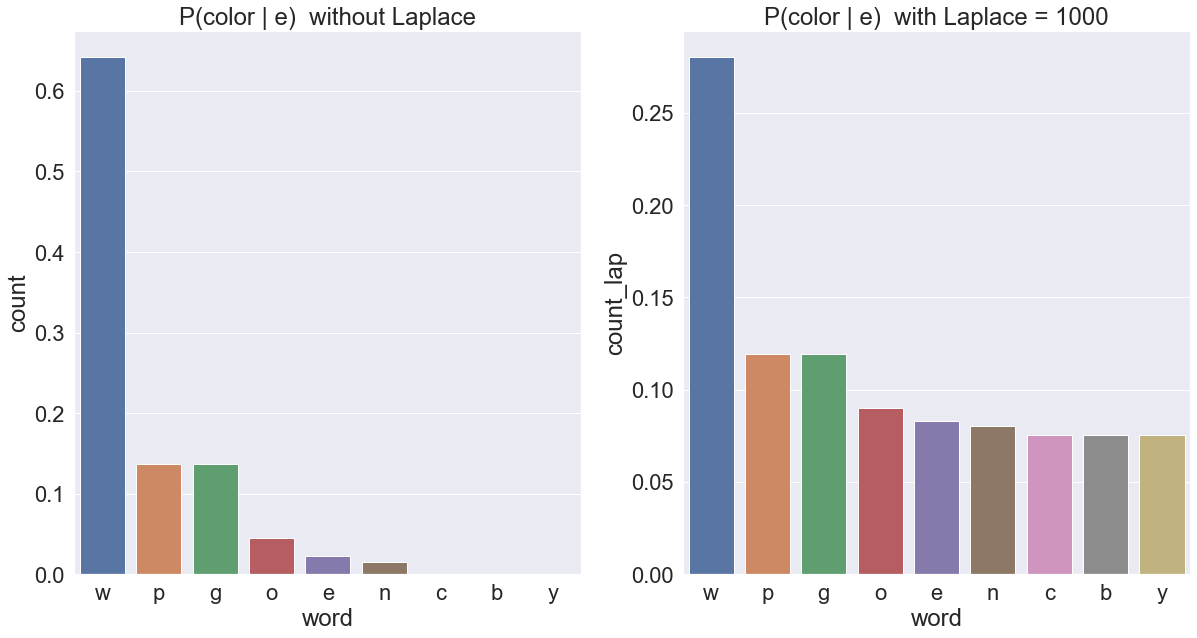

In [28]:
now_data = mush_data.loc[mush_data[mush_header[0]] == 'e']
tar_tags = 'stalk-color-below-ring'

col_list = list(set(mush_data[tar_tags].tolist()))
num_feat = len(col_list)
num_alle = now_data.shape[0]

dic = {}
for i in col_list:
    tmp = now_data.loc[now_data[tar_tags] == i]
    dic[i] = tmp.shape[0]

LAP_K = 1000
words = []
couts = []
count_lap = []

for i in dic:
    words.append(i)
    couts.append(dic[i] / num_alle)
    count_lap.append((dic[i] + LAP_K) / (num_alle + LAP_K * num_feat))
    
df = pd.DataFrame({ "word" : words, "count" : couts, "count_lap" : count_lap})
df = df.sort_values("count",ascending=False)

sns.set(font_scale = 2, rc = {'figure.figsize':(11.7,8.27)})
fig, axes = plt.subplots(1, 2, sharex = False, figsize=(20, 10))


p = sns.barplot(x = "word", y = "count", data = df, ax = axes[0])
p.set(title = "P(color | e)  without Laplace")

p = sns.barplot(x = "word", y = "count_lap", data = df, ax = axes[1])
p.set(title = "P(color | e)  with Laplace = 1000")

#### Q2. What are the values of 𝜇 and 𝜎 of assumed 𝑃(𝑋𝑝𝑒𝑡𝑎𝑙_𝑙𝑒𝑛𝑔𝑡ℎ|𝑌=Iris Versicolour)? 
#### Q3. Use a graph to show the probability density function of assumed 𝑃(𝑋𝑝𝑒𝑡𝑎𝑙_𝑙𝑒𝑛𝑔𝑡ℎ|𝑌=Iris Versicolour)

𝜇  = 4.35, 𝜎 = 0.4651881339845203


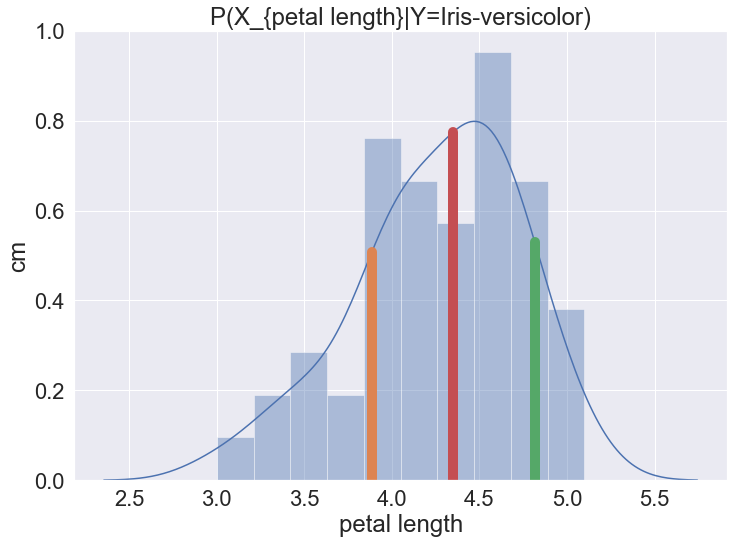

In [29]:
now_data = iris_data.loc[iris_data[iris_header[-1]] == 'Iris-versicolor']

tar_tags = 'petal length'
now_data = now_data[tar_tags]

p = sns.distplot(x = now_data, bins = 10)
p.set(xlabel = tar_tags, ylabel = "cm")

median = np.median(now_data)
sigma = np.std(now_data)

low = median - sigma
hi = median + sigma

line = p.lines[0].get_data()
ipf = interp1d(x=line[0], y=line[1])

p.plot([low, low], [0, ipf(low)], linewidth = now_linewidt)
p.plot([hi, hi], [0, ipf(hi)], linewidth = now_linewidt)
p.plot([median, median], [0, ipf(median)], linewidth = now_linewidt)
p.set(title = "P(X_{petal length}|Y=Iris-versicolor)")

print(f"𝜇  = {median}, 𝜎 = {sigma}")